In [1]:
import clip
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from os.path import expanduser, join
from torchvision.transforms import ToTensor, ToPILImage
from matplotlib import pyplot as plt
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
trained_clip, preprocess = clip.load("ViT-B/32", device="cuda")

In [3]:
data_path = expanduser('~/datasets')
cifar_train_val = CIFAR10(join(data_path, 'Cifar10'), transform=preprocess, train=True)
cifar_test = CIFAR10(join(data_path, 'Cifar10'), transform=preprocess, train=False)

cifar_train, cifar_val = torch.utils.data.random_split(cifar_train_val, (40_000,10_000))

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar_val, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=256, shuffle=True)


In [4]:
x_test, y_test = next(iter(train_loader))

In [5]:
x_test.shape, y_test.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

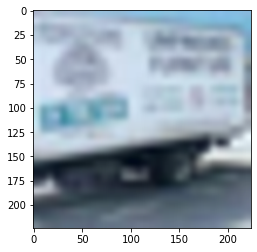

In [6]:
def unprocess(img):
    img = img.permute(1,2,0)
    img = img - img.min()
    return img / img.max()

plt.imshow(unprocess(x_test[0]))

In [4]:
class simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.classifier = nn.Linear(224*224*3,10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.classifier(self.flat(x)))
        return x
        
# simple_model = simple()
# res = simple_model(x_test)
# res.shape

In [5]:
class simple_clip(nn.Module):
    def __init__(self, clip):
        super().__init__()
        self.encoder = clip.encode_image
        self.classifier = nn.Linear(512,10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x.float())
        x = self.relu(x)
        return x

# clip_model = simple_clip(trained_clip)
# res = simple_model(x_test)
# res.shape

In [6]:
import numpy as np

def train(model, train_loader, loss_fn, optimizer):
    model.train()
    epoch_loss = []
    epoch_acc = []
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        pred = model(data)
        loss = loss_fn(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        acc = torch.mean(torch.argmax(pred,1) == target)
        epoch_acc.append(acc.item())
    return np.mean(epoch_loss), np.mean(epoch_acc)

def val(model, loader, loss_fn):
    model.eval()
    with torch.no_grad():
        epoch_loss = []
        epoch_acc = []
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            pred = model(data)
            loss = loss_fn(pred, target)

            epoch_loss.append(loss.item())
            acc = torch.mean(torch.argmax(pred,1) == target)
            epoch_acc.append(acc.item())

        return np.mean(epoch_loss), np.mean(epoch_acc)

    
def do_training(model, train_loader, val_loader, optimizer, loss, epochs):
         
    train_losses = []
    train_accs = []
    
    val_losses = []
    val_accs = []
        
    for epoch in range(epochs):
        e_train_loss, e_train_acc = train(model, train_loader, loss, optimizer)
        
        train_losses.append(e_train_loss)
        train_accs.append(e_train_acc)
        
        
        e_val_loss, e_val_acc = val(model, val_loader, loss)
        
        val_losses.append(e_val_loss)
        val_accs.append(e_val_acc)
        
        print(epoch)
        print(e_train_loss, e_train_acc, e_val_loss, e_val_acc)
        
    return train_losses, train_accs, val_losses, val_accs

    
    
def plotting(train_losses, train_accs, val_losses, val_accs):
    _, ax = plt.subplots(1, 2, figsize= (14, 6))
    ax[0].set_title("loss train vs val")
    ax[0].plot(train_losses, label="training")
    ax[0].plot(val_losses, label="validation")
    ax[0].legend()
    
    ax[1].set_title("acc train vs val")
    ax[1].plot(train_accs, label="training")
    ax[1].plot(val_accs, label="validation")
    ax[1].legend()
    plt.show()

In [19]:
simple_model = simple().to(device)
optimizer = torch.optim.Adam(simple_model.parameters(), lr = 0.01)
loss = nn.CrossEntropyLoss()

train_losses, train_accs, val_losses, val_accs = do_training(simple_model, train_loader, val_loader, optimizer, loss, 10)

0
74.7225696888699 48.76433121019108 74.37064636133279 47.30573248407644
1
59.92556825868643 51.095541401273884 69.19922015925123 45.68789808917197
2
61.00520372087029 50.3312101910828 60.608958493372434 55.0
3
58.788208177894546 50.732484076433124 52.78975658052286 52.388535031847134
4
55.250477541783816 50.92356687898089 58.246203112754095 49.35668789808917
5
58.512146117580926 51.05732484076433 54.03376658251331 51.36942675159236
6
56.715265213304264 51.203821656050955 60.76822152107385 48.86624203821656
7
56.66982602161966 50.038216560509554 54.33511182457019 50.88535031847134
8
55.19189255100906 49.87261146496815 56.132834076122116 49.46496815286624
9
57.12045727869508 49.40127388535032 83.0815833753841 46.98089171974522


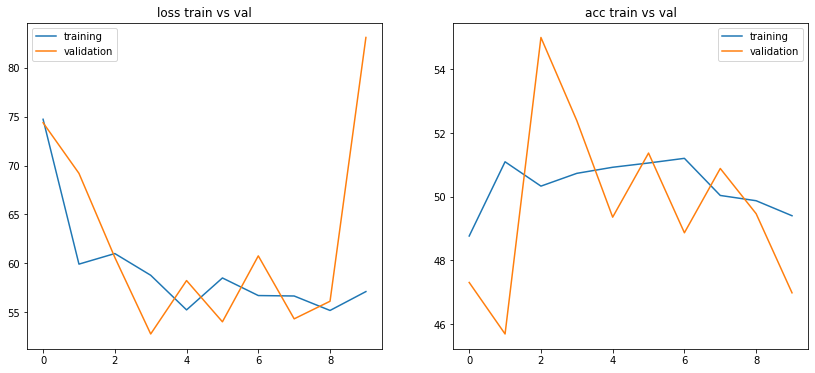

In [20]:
plotting(train_losses, train_accs, val_losses, val_accs)

In [7]:
clip_model = simple_clip(trained_clip).to(device)
optimizer = torch.optim.Adam(clip_model.parameters(), lr = 0.01)
loss = nn.CrossEntropyLoss()

train_losses, train_accs, val_losses, val_accs = do_training(clip_model, train_loader, val_loader, optimizer, loss, 10)

0
0.9161238066709725 167.05095541401275 0.832375040099879 170.85987261146497
1
0.8305454356655194 170.69426751592357 0.8161359801413907 171.47770700636943
2
0.8194312495031174 171.0891719745223 0.8082582961981464 171.84076433121018
3
0.8124847358958737 171.54777070063693 0.8024655197076737 172.03184713375796
4
0.8071916596904681 171.7579617834395 0.7977627625890599 172.17834394904457
5
0.8039587903174625 171.88535031847132 0.796566578233318 172.7388535031847
6
0.8026783770057047 171.8535031847134 0.7970398003887978 172.171974522293
7
0.8022389499245176 171.9171974522293 0.7908777993196136 172.9044585987261
8
0.7999066216930463 172.1464968152866 0.7955912260492896 172.29936305732485
9
0.7978139010963926 171.97452229299364 0.7863775089288213 172.87261146496814


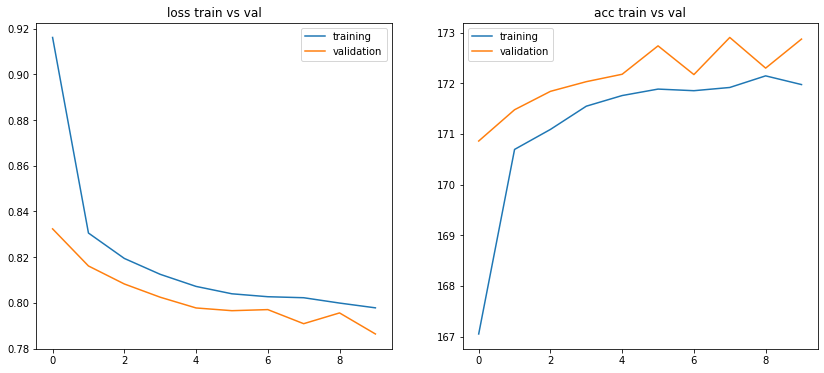

In [8]:
plotting(train_losses, train_accs, val_losses, val_accs)